# Import libraries needed

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# Importing Sequential Feature Selector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Read Dataset and get an overview

In [64]:
# Read the dataset to a dataframe (below is an example dataframe as an example)
data = pd.read_csv("../../datasets/healthcare_data.csv")

In [65]:
# Copying data to another variable to avoid any changes to original data
same_data = data.copy()

In [66]:
# View the first 5 rows of the dataset
data.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,NaN,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [67]:
# View the last 5 rows of the dataset
data.tail()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
499995,4,gynecology,F,Dr Sarah,2,43001,11-20,Female,Trauma,Minor,High Blood Pressure,3,No,4105.795901,10
499996,13,gynecology,F,Dr Olivia,8,85601,31-40,Female,Emergency,Moderate,Other,2,No,4631.550257,11
499997,2,gynecology,B,Dr Sarah,3,22447,11-20,Female,Emergency,Moderate,High Blood Pressure,2,No,5456.930075,8
499998,2,radiotherapy,A,Dr John,1,29957,61-70,Female,Trauma,Extreme,Diabetes,2,No,4694.127772,23
499999,3,gynecology,F,Dr Sophia,3,45008,41-50,Female,Trauma,Moderate,Heart disease,4,Yes,4713.868519,10


In [68]:
# Understand the shape of the data
data.shape

(500000, 15)

In [69]:
# Checking the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  500000 non-null  int64  
 1   Department                         500000 non-null  object 
 2   Ward_Facility_Code                 500000 non-null  object 
 3   doctor_name                        500000 non-null  object 
 4   staff_available                    500000 non-null  int64  
 5   patientid                          500000 non-null  int64  
 6   Age                                500000 non-null  object 
 7   gender                             500000 non-null  object 
 8   Type of Admission                  500000 non-null  object 
 9   Severity of Illness                500000 non-null  object 
 10  health_conditions                  348112 non-null  object 
 11  Visitors with Patient              5000

In [70]:
# Checking the descriptive statistics of the columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Available Extra Rooms in Hospital,500000.0,3.638800,2.698124,0.000000,2.000000,3.000000,4.000000,24.00000
staff_available,500000.0,5.020470,3.158103,0.000000,2.000000,5.000000,8.000000,10.00000
patientid,500000.0,63150.519058,41689.479956,-3269.000000,25442.000000,57864.000000,103392.000000,134400.00000
Visitors with Patient,500000.0,3.549414,2.241054,0.000000,2.000000,3.000000,4.000000,32.00000
Admission_Deposit,500000.0,4722.315734,1047.324220,1654.005148,4071.714532,4627.003792,5091.612717,10104.72639
Stay (in days),500000.0,12.381062,7.913174,3.000000,8.000000,9.000000,11.000000,51.00000


In [71]:
# Checking for duplicate values in the data
data.duplicated().sum()

0

In [72]:
# Get the list of column names with 'object' data type
object_columns = [col for col in data.columns if data[col].dtype == 'object']
numeric_columns = [col for col in data.columns if data[col].dtype == 'int64' or data[col].dtype == 'float64']

# Printing the number of occurrences of each unique value in each categorical column
for column in object_columns:
    print(data[column].value_counts(1))
    print("-" * 50)

Department
gynecology            0.686956
radiotherapy          0.168630
anesthesia            0.088358
TB & Chest disease    0.045780
surgery               0.010276
Name: proportion, dtype: float64
--------------------------------------------------
Ward_Facility_Code
F    0.241076
D    0.238110
B    0.207770
E    0.190748
A    0.093102
C    0.029194
Name: proportion, dtype: float64
--------------------------------------------------
doctor_name
Dr Sarah     0.199192
Dr Olivia    0.196704
Dr Sophia    0.149506
Dr Nathan    0.141554
Dr Sam       0.111422
Dr John      0.102526
Dr Mark      0.088820
Dr Isaac     0.006718
Dr Simon     0.003558
Name: proportion, dtype: float64
--------------------------------------------------
Age
21-30     0.319586
31-40     0.266746
41-50     0.160812
11-20     0.093072
61-70     0.053112
51-60     0.043436
71-80     0.037406
81-90     0.016362
0-10      0.006736
91-100    0.002732
Name: proportion, dtype: float64
------------------------------------------

# Exploratory Data Analysis

## Univariate Analysis

In [73]:
# Function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # x-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )                   # Creating the 2 subplots
    sns.boxplot(data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )                   # Boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )                   # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )                   # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )                   # Add median to the histogram

In [74]:
print(numeric_columns)

['Available Extra Rooms in Hospital', 'staff_available', 'patientid', 'Visitors with Patient', 'Admission_Deposit', 'Stay (in days)']


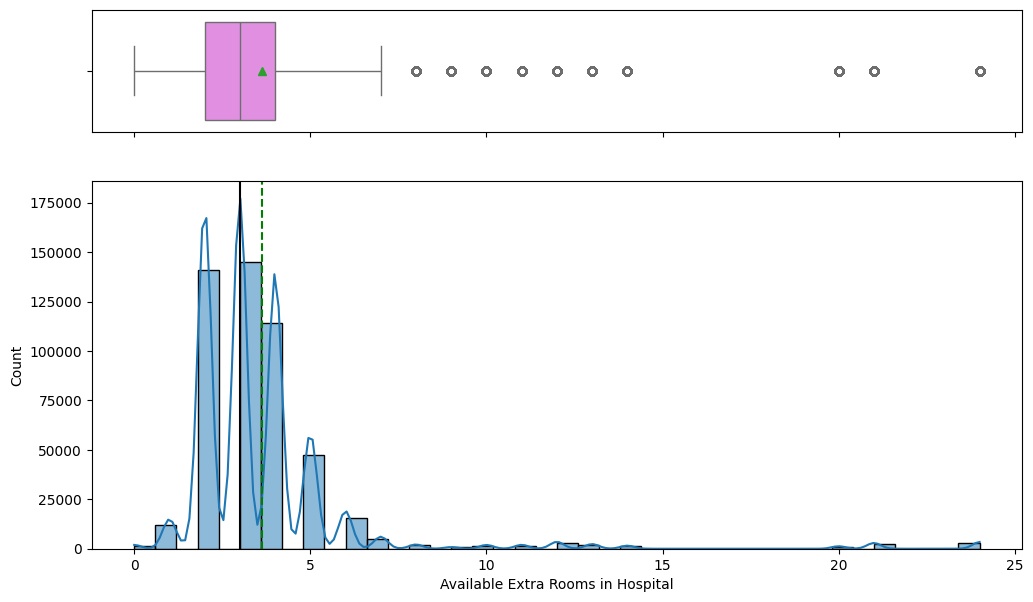

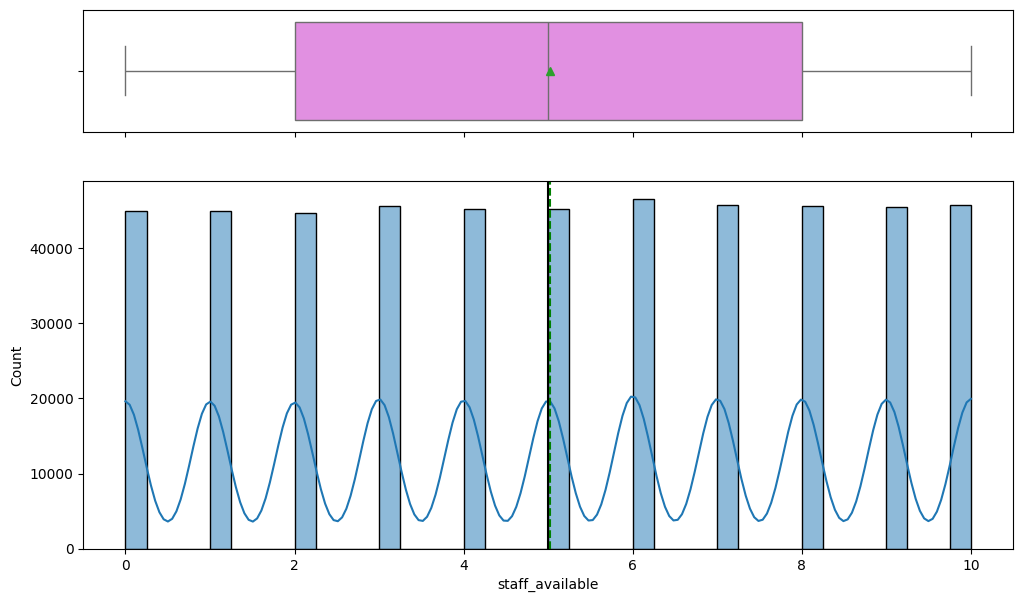

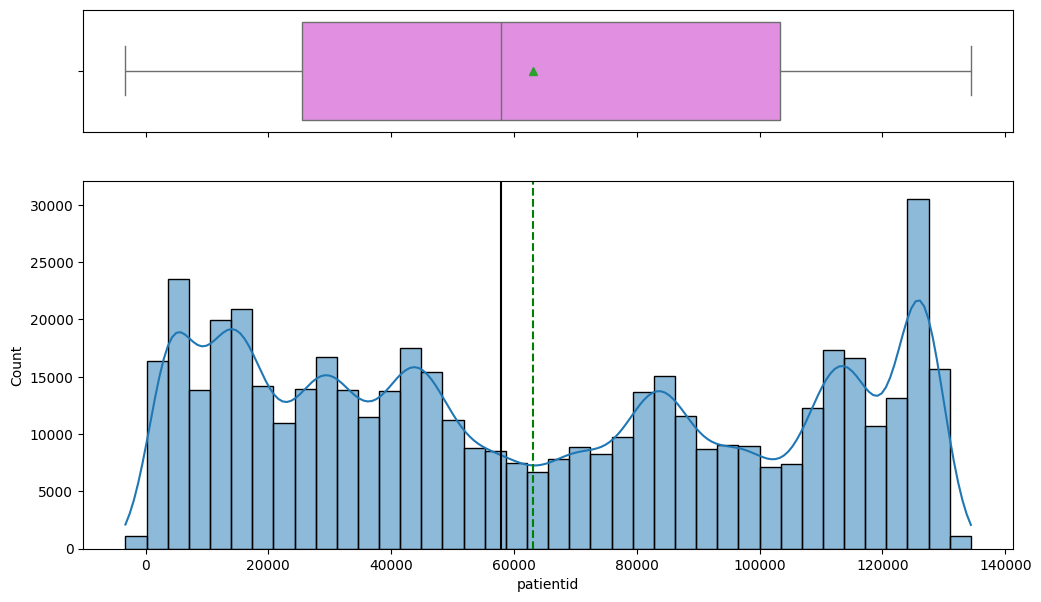

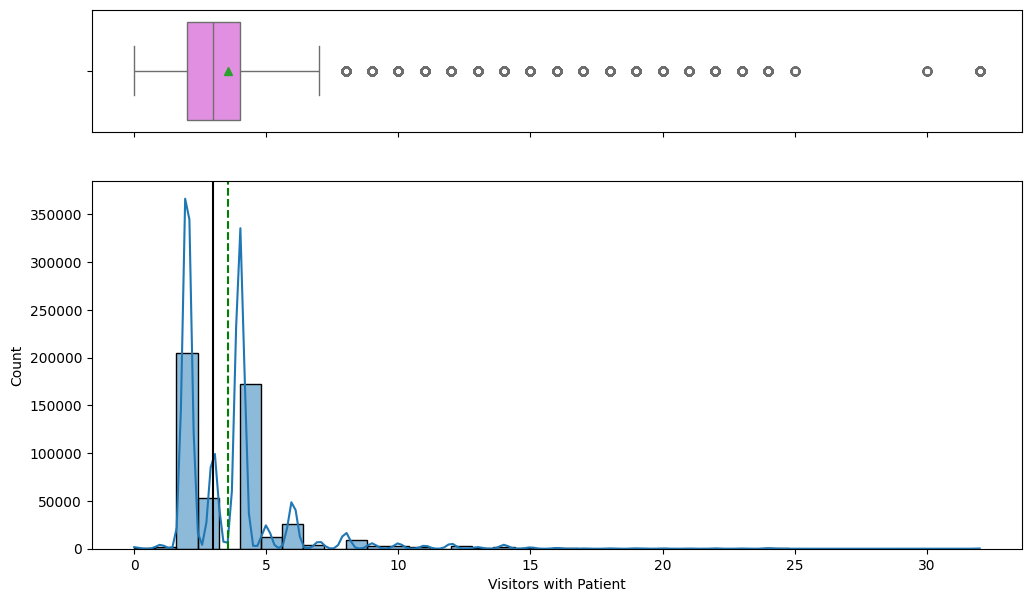

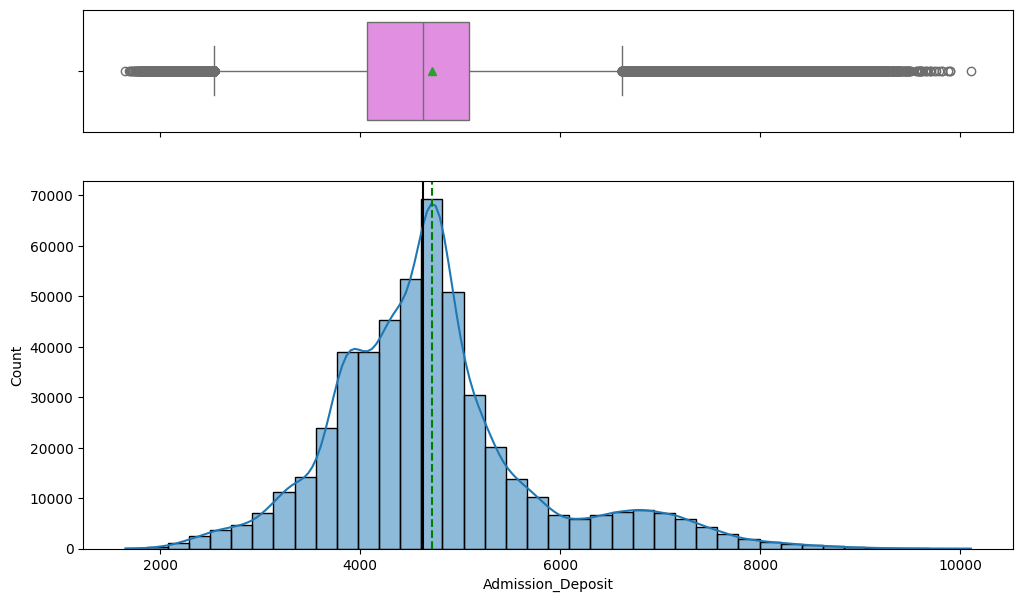

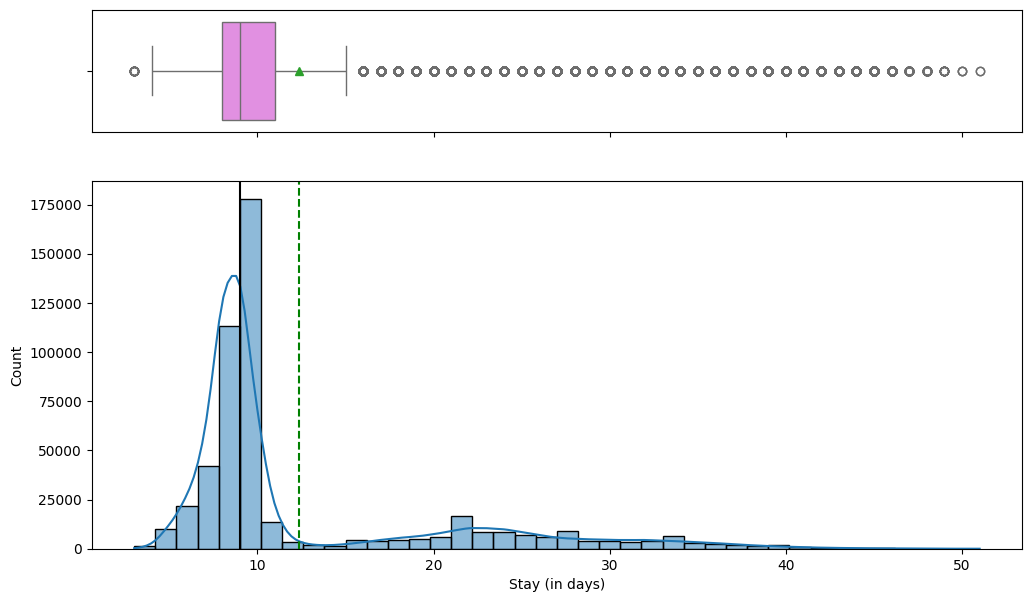

In [75]:
# Printing the number of occurrences of each unique value in each categorical column
for var in numeric_columns:
    histogram_boxplot(data, var, kde = True, bins=40)

## Bi-Variate Analysis

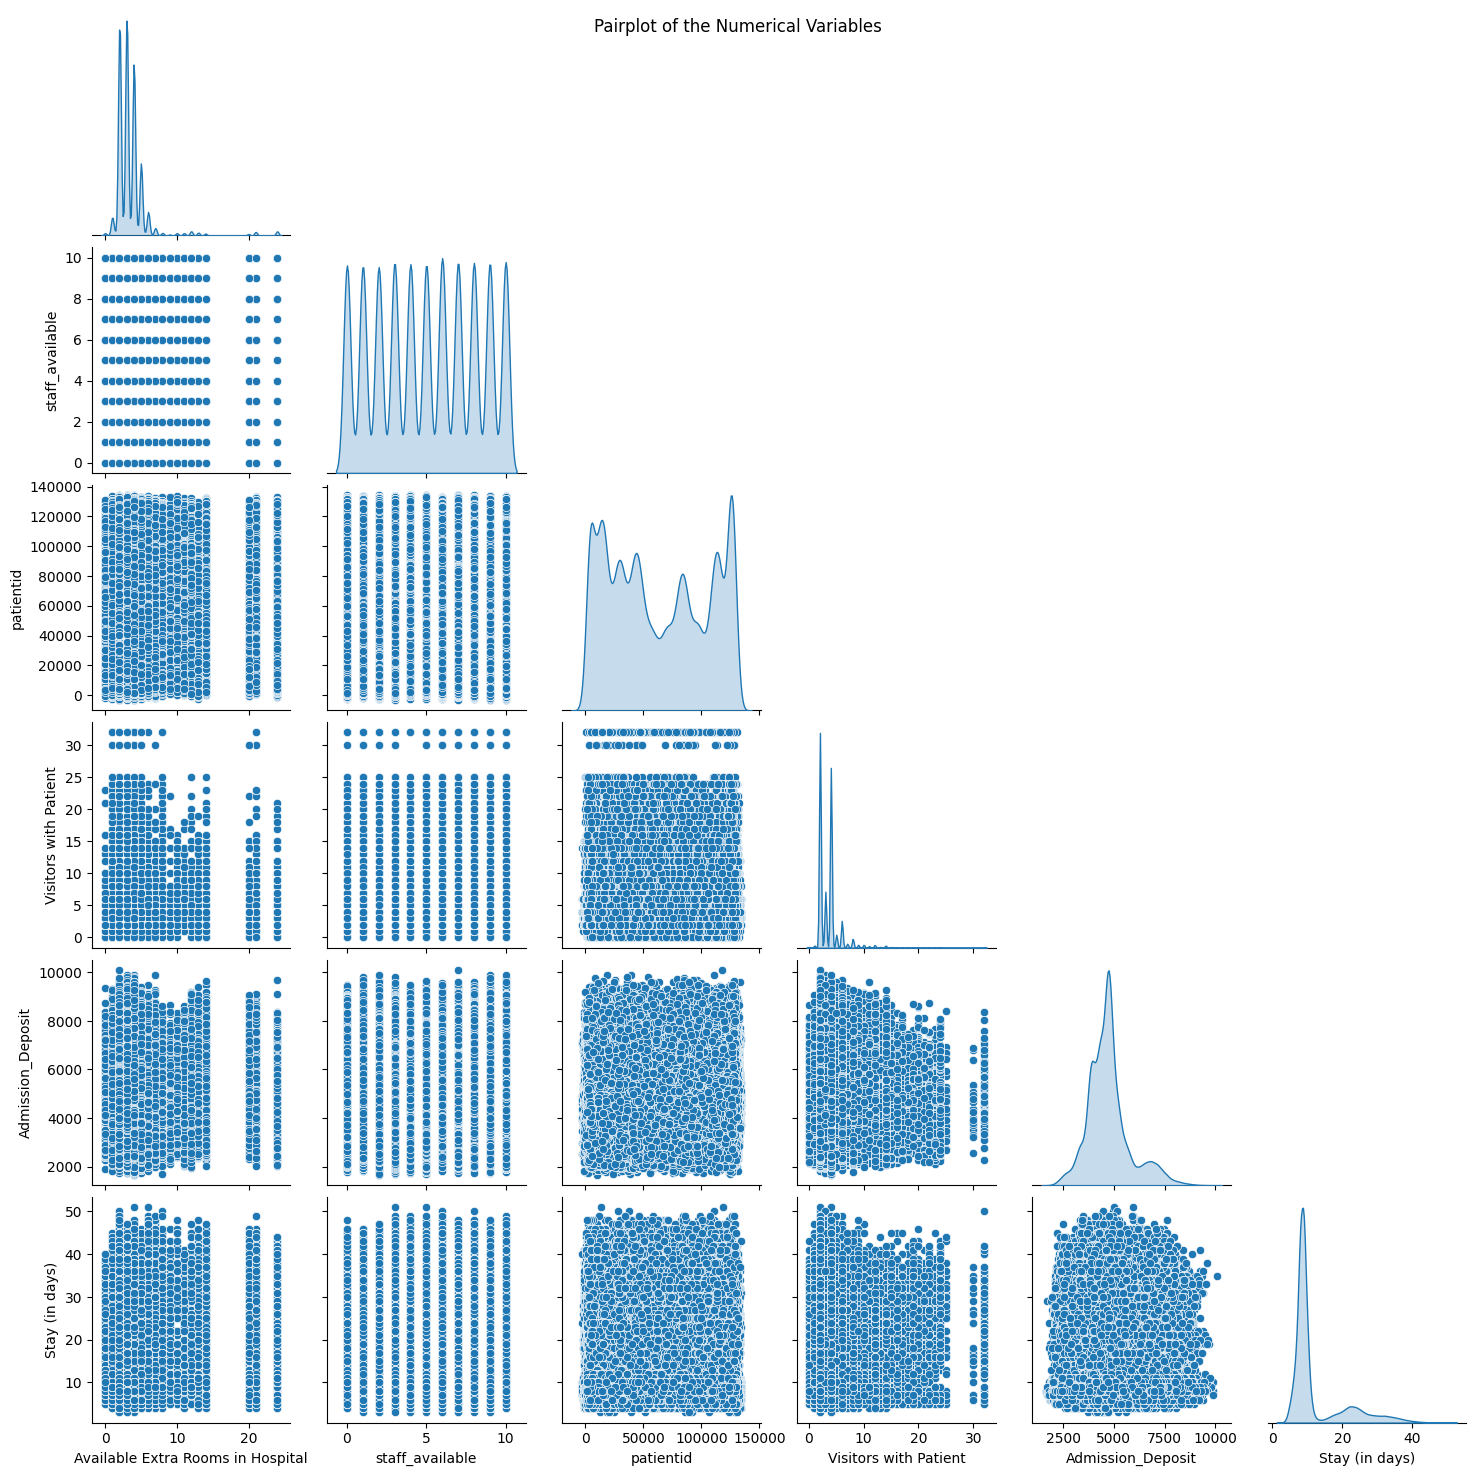

In [76]:
# use a pair plot to look at the distrubution and the correlation between the numeric variables
sns.pairplot(data=data, vars=numeric_columns, corner=True, diag_kind="kde")

# set the title and show the plot
plt.suptitle("Pairplot of the Numerical Variables")
plt.show()

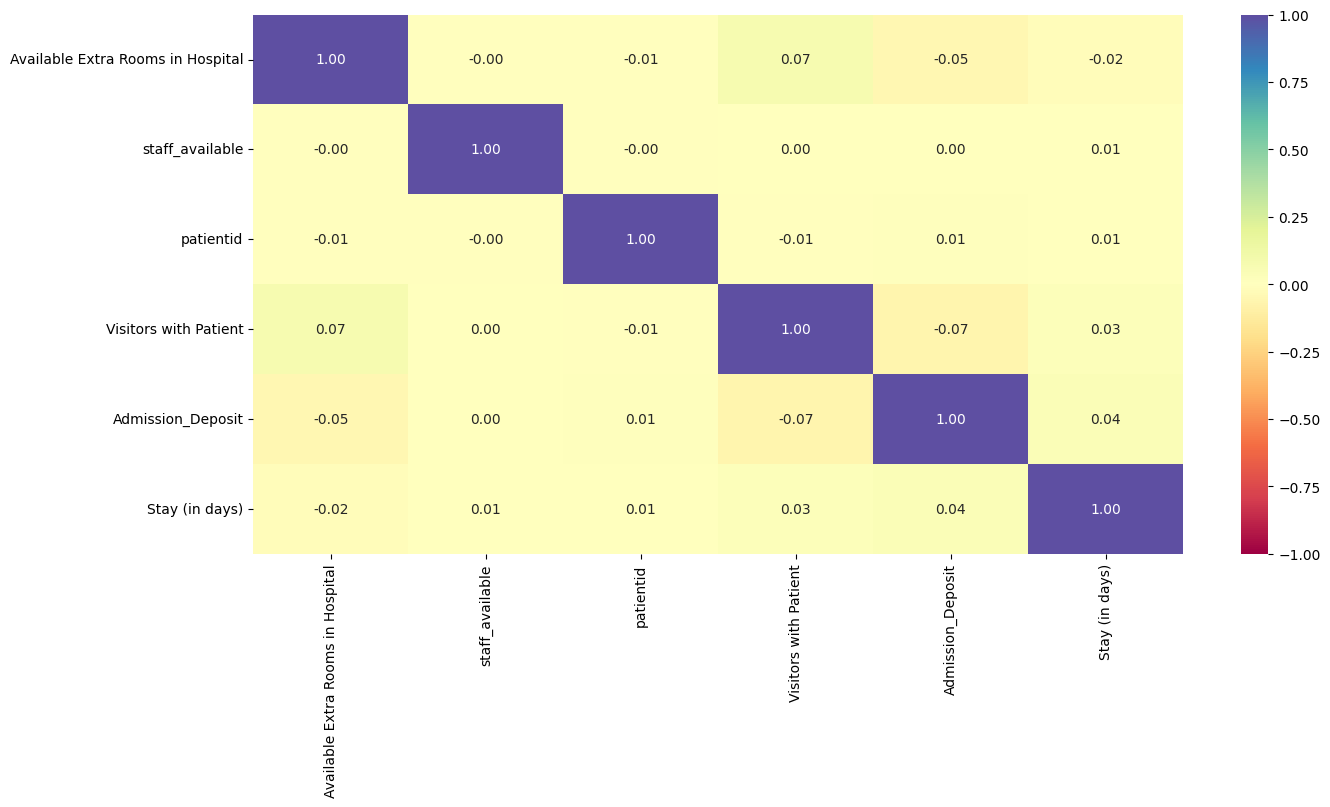

In [77]:
# set the plot size
plt.figure(figsize = (15, 7))

# create a correlation matrix, and plot it in the heatmap
sns.heatmap(data[numeric_columns].corr(), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")

# show the plot
plt.show()

also look at tboxplots, barplots and others to see what we can gleen from those.

# Data Pre-Processing

## **Data Preparation for Model Building**

- Before we proceed to build a model, we'll have to encode categorical features.
- Separate the independent variables and dependent Variables.
- We'll split the data into train and test to be able to evaluate the model that we train on the training data.

In [78]:
# Dont forget to drop any columns like id's etc..
# Dropping patientid from the data as it is an identifier and will not add value to the analysis
data=data.drop(columns=["patientid"])

In [79]:
# Creating dummy variables for the categorical columns
# drop_first=True is used to avoid redundant variables
data = pd.get_dummies(
    data,
    columns = data.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
    dtype=int,
)

In [80]:
# Check the data after handling categorical data
data

,Available Extra Rooms in Hospital,staff_available,Visitors with Patient,Admission_Deposit,Stay (in days),Department_anesthesia,Department_gynecology,Department_radiotherapy,Department_surgery,Ward_Facility_Code_B,Ward_Facility_Code_C,Ward_Facility_Code_D,Ward_Facility_Code_E,Ward_Facility_Code_F,doctor_name_Dr John,doctor_name_Dr Mark,doctor_name_Dr Nathan,doctor_name_Dr Olivia,doctor_name_Dr Sam,doctor_name_Dr Sarah,doctor_name_Dr Simon,doctor_name_Dr Sophia,Age_11-20,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100,gender_Male,gender_Other,Type of Admission_Trauma,Type of Admission_Urgent,Severity of Illness_Minor,Severity of Illness_Moderate,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_Other,Insurance_Yes
0,4,0,4,2966.408696,8,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,4,2,2,3554.835677,9,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
2,2,8,2,5624.733654,7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,4,7,4,4814.149231,8,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,2,10,2,5169.269637,34,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,4,2,3,4105.795901,10,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
499996,13,8,2,4631.550257,11,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
499997,2,3,2,5456.930075,8,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
499998,2,1,2,4694.127772,23,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [81]:
# Separating independent variables and the target variable
x = data.drop('Stay (in days)',axis=1)
y = data['Stay (in days)'] 

In [82]:
# Splitting the dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

In [83]:
# Checking the shape of the train and test data
print("Shape of Training set : ", x_train.shape)
print("Shape of Test set : ", x_test.shape)

Shape of Training set :  (400000, 41)
Shape of Test set :  (100000, 41)


# Define performance metrics

* We will be using different metrics functions defined in sklearn like RMSE, MAE, 𝑅2, Adjusted 𝑅2, and MAPE for regression models evaluation. We will define a function to calculate these metric.
* The mean absolute percentage error (MAPE) measures the accuracy of predictions as a percentage, and can be calculated as the average of absolute percentage error for all data points. The absolute percentage error is defined as predicted value minus actual values divided by actual values. It works best if there are no extreme values in the data and none of the actual values are 0.

In [84]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

# Train ML Models

In [85]:
# Statsmodel API does not add a constant by default. We need to add it explicitly.
x_train1 = sm.add_constant(x_train)

# Add constant to test data
x_test1 = sm.add_constant(x_test)



In [86]:
# Train the model
olsmodel1 = sm.OLS(y_train, x_train1).fit()

# Get the model summary
olsmodel1.summary()
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:         Stay (in days)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 5.796e+04
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:23:14   Log-Likelihood:            -1.0246e+06
No. Observations:              400000   AIC:                         2.049e+06
Df Residuals:                  399962   BIC:                         2.050e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [87]:
lin_reg_test = model_performance_regression(olsmodel1, x_test1, y_test)
lin_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842962,19.676966


Observations:

We can observe that R-squared for the model is ~0.84.
Not all the variables are statistically significant enough to predict the outcome variable. To check which ones are statistically significant or have enough predictive power to predict the target variable, we check the p-value for all the independent variables. Independent variables with a p-value of higher than 0.05 are not significant for the 95% confidence level.
Interpreting the Regression Results:

Adjusted R-squared: It reflects the fit of the model.

R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
In our case, the value for Adj. R-squared is 0.84
coef: It represents the change in the output Y due to a change of one unit in the variable (everything else held constant).

std err: It reflects the level of accuracy of the coefficients.

The lower it is, the more accurate the coefficients are.
P > |t|: The p-value:

Pr(>|t|): For each independent feature there is a null hypothesis and an alternate hypothesis

Ho: Null Hypothesis - The independent feature is not significant

Ha: Alternate Hypothesis - The independent feature is significant

A p-value of less than 0.05 is considered to be statistically significant.

Confidence Interval: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).
Both the R-squared and Adjusted R-squared of the model are around 84%. This is a clear indication that we have been able to create a good model that can explain variance in the LOS of patients for up to 84%.

We can examine the significance of the regression model, and try dropping insignificant variables.

In [88]:
print("Performance on train data: ")
model_performance_regression(olsmodel1, x_train1, y_train)

Performance on train data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135093,2.146244,0.842813,0.842796,19.591833


In [89]:
print("Performance on test data: ")
model_performance_regression(olsmodel1, x_test1, y_test)

Performance on test data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842962,19.676966


Observations:

The Root Mean Squared Error of train and test data are very close, indicating that our model is not overfitting to the training data.

Mean Absolute Error (MAE) indicates that the current model can predict LOS of patients within mean error of 2.15 days on the test data.

The units of both RMSE and MAE are the same - days in this case. But RMSE is greater than MAE because it penalizes the outliers more.

Mean Absolute Percentage Error is ~19% on the test data, indicating that the average difference between the predicted value and the actual value is ~19%

## Check for multicollinearity

**Multicollinearity** occurs when **independent variables** in a regression model are **highly correlated** to each other, such that they do not provide **unique** or independent information. A regression coefficient is interpreted as the mean change in the target for each unit change in a feature when all other characteristics are held constant. Changes in one aspect can affect other features when they are correlated. The stronger the relationship, the more difficult it is to change one element without affecting the others. Because the features tend to change concurrently, it becomes difficult for the model to evaluate the link between each variable and the target individually.

**Variation Inflation Factor (VIF)** is one of the most common ways of detecting multicollinearity in data. The Variation Inflation Factor (VIF) is one of the most common methods for detecting multicollinearity in data. The VIF calculates how much the variance of a regression coefficient is inflated due to model multicollinearity. 

The VIF can be calculated in two steps,
*   Choose and execute a regression analysis on an independent variable for which you are attempting to calculate VIF. For example, suppose there are three independent variables X1, X2, and X3, and a target variable Y. If we wish to calculate VIF for the variable X1, we use X1 as the target variable and X2 and X3 as independent variables **(X1=b0+b1.X2+b2.X3)**.
* The regression model mentioned above gives us R2 squared. The formula below is used to calculate the VIF using R2.

> ![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/vif.jpg)

Variance inflation factor (VIFs) tells **"what percentage of the variance is inflated for each coefficient"**. For example, a VIF of 1.7 tells you that the variance of a particular coefficient is 70% bigger than what you would expect if there was no multicollinearity, i.e., if there was no correlation with other predictors. 

Usually, features having a VIF score greater than 5 are dropped/treated till all the features have a VIF score of less than 5.

In [92]:
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif

In [93]:
print(checking_vif(x_train1))

                                  feature        VIF
0                                   const   0.000000
1       Available Extra Rooms in Hospital   1.023185
2                         staff_available   1.001928
3                   Visitors with Patient   1.029215
4                       Admission_Deposit   1.021075
5                   Department_anesthesia   2.737453
6                   Department_gynecology        inf
7                 Department_radiotherapy   7.650799
8                      Department_surgery        inf
9                    Ward_Facility_Code_B        inf
10                   Ward_Facility_Code_C   1.366865
11                   Ward_Facility_Code_D        inf
12                   Ward_Facility_Code_E   2.878866
13                   Ward_Facility_Code_F        inf
14                    doctor_name_Dr John        inf
15                    doctor_name_Dr Mark        inf
16                  doctor_name_Dr Nathan        inf
17                  doctor_name_Dr Olivia     

- All the continuous variables have VIF less than 5, which makes sense according to what we observed in correlation heatmap.

**Note:** It is not a good practice to consider VIF values for dummy variables as they are correlated to other categories and hence have a high VIF usually. In such a case, we can check the p-values of coefficients.

## **Dropping the insignificant variables and creating the regression model again**

### **Examining the significance of the model**

It is not enough to just fit a multiple regression model to the data, it is also necessary to check whether all the regression coefficients are significant or not. The significance here means whether the population regression parameters are significantly different from zero.

From the above, it may be noted that the regression coefficients corresponding to staff_available, Visitors with Patient, and Insurance_Yes **are not statistically significant at significance level α = 0.05.** In other words, the regression coefficients corresponding to these three are not significantly different from 0 in the population. 

Suppose you have a nominal categorical variable having 4 categories (or levels). You would create 3 dummy variables (k-1 = 4-1 dummy variables) and set one category as a reference level. Suppose one of them is insignificant, then if you exclude that dummy variable, it would change the reference level as you are indirectly combining that insignificant level with the original reference level. It would have a new reference level and interpretation would change. Moreover, excluding the level may make the others insignificant. If all the categories in a column show p-value higher than 0.05, then we can drop that column.

**Hence, we will eliminate these three features and create a new model.**

In [94]:
# Dropping variables
x_train2 = x_train1.drop(['Insurance_Yes','staff_available','Visitors with Patient'], axis = 1)
x_test2 = x_test1.drop(['Insurance_Yes','staff_available','Visitors with Patient'], axis = 1)

# Train the model
olsmodel2 = sm.OLS(y_train, x_train2).fit()

# Get the model summary
olsmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Stay (in days)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 6.307e+04
Date:                Thu, 08 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:28:47   Log-Likelihood:            -1.0246e+06
No. Observations:              400000   AIC:                         2.049e+06
Df Residuals:                  399965   BIC:                         2.050e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    19.8886      0.053    373.758      0.000      19.784      19.993
Available Extra Rooms in Hospital         0.0786      0.002     42.391      0.000       0.075       0.082
Admission_Deposit                     -3.842e-05   4.77e-06     -8.051      0.000   -4.78e-05   -2.91e-05
Department_anesthesia                     6.0822      0.029    210.152      0.000       6.025       6.139
Department_gynecology                     0.4628      0.019     24.518      0.000       0.426       0.500
Department_radiotherapy                  -4.6217      0.037   -126.175      0.000      -4.694      -4.550
Department_surgery                        9.6854      0.044    218.982      0.000       9.599       9.772
Ward_Facility_Code_B                      0.2569      0.011     23.599      0.000       0.236       0.278
Ward_Facility_Code_C                      0.4350      0.034     12.611      0.000       0.367       0.503
Ward_Facility_Code_D                      0.2032      0.010     19.495      0.000       0.183       0.224
Ward_Facility_Code_E                      0.3085      0.021     14.438      0.000       0.267       0.350
Ward_Facility_Code_F                      0.0027      0.011      0.248      0.804      -0.019       0.024
doctor_name_Dr John                       7.2624      0.031    236.018      0.000       7.202       7.323
doctor_name_Dr Mark                       1.1947      0.033     36.462      0.000       1.130       1.259
doctor_name_Dr Nathan                    -0.2125      0.015    -14.014      0.000      -0.242      -0.183
doctor_name_Dr Olivia                    -0.3592      0.015    -24.646      0.000      -0.388      -0.331
doctor_name_Dr Sam                        1.2833      0.038     33.914      0.000       1.209       1.358
doctor_name_Dr Sarah                      0.8184      0.016     50.617      0.000       0.787       0.850
doctor_name_Dr Simon                      6.1594      0.069     89.118      0.000       6.024       6.295
doctor_name_Dr Sophia                     0.2162      0.020     10.584      0.000       0.176       0.256
Age_11-20                               -12.7379      0.065   -194.593      0.000     -12.866     -12.610
Age_21-30                               -10.4831      0.062   -168.470      0.000     -10.605     -10.361
Age_31-40                               -13.4355      0.062   -216.959      0.000     -13.557     -13.314
Age_41-50                               -13.5114      0.062   -216.835      0.000     -13.634     -13.389
Age_51-60                                -0.3666      0.065     -5.652      0.000      -0.494      -0.239
Age_61-70                                -0.4217      0.064     -6.592      0.000      -0.547      -0.296
Age_71-80

### **Checking the performance of the model on the train and test datasets**

In [95]:
print("Performance on train data: ")
model_performance_regression(olsmodel2, x_train2, y_train)

Performance on train data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135098,2.146237,0.842812,0.842797,19.591701


In [96]:
print("Performance on test data: ")
lin_reg_test = model_performance_regression(olsmodel2, x_test2, y_test)
lin_reg_test

Performance on test data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144053,2.155762,0.843028,0.842967,19.676967


**Observation:**

* RMSE, MAE, and MAPE of train and test data are very close, indicating that the **model is not overfitting and has generalized well over the unseen data.**

# **Checking for assumptions and rebuilding the model**

In this step, we will check for the below assumptions in the model, to verify if they hold true or not. If the assumptions of model are not satisfied, then the model might give false results. Hence, if any of the assumptions is not true, then we will rebuild the model after fixing those issues.

1. Mean of residuals should be 0
2. Normality of error terms
3. Linearity of variables
4. No Heteroscedasticity

### **Mean of residuals should be 0 and normality of error terms**

In [97]:
# Residuals
residual = olsmodel2.resid 
residual.mean()

-2.4402510234722285e-12

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

## **Tests for Normality**

**What is the test?**

* Error terms/Residuals should be normally distributed.

* If the error terms are non-normally distributed, confidence intervals may become too wide or narrow. Once the confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on the minimization of least squares.

**What does non-normality indicate?**

* It suggests that there are a few unusual data points that must be studied closely to make a better model.

**How to check the normality?**

* It can be checked via QQ Plot. Residuals following normal distribution will make a straight line plot otherwise not.

* Another test to check for normality is the Shapiro-Wilk test.

**What if the residuals are not-normal?**

* We can apply transformations like a log, exponential, arcsinh, etc. as per our data.

<Axes: ylabel='Count'>

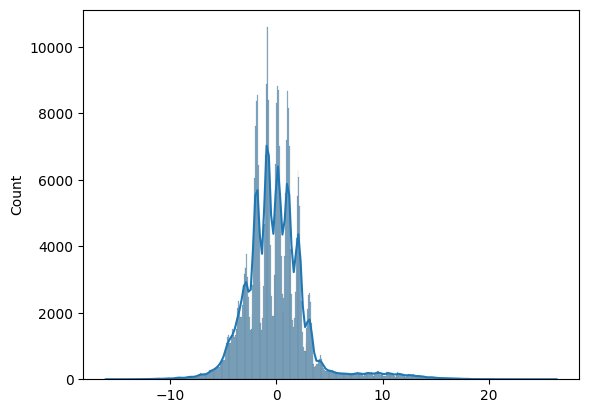

In [98]:
# Plot histogram of residuals
sns.histplot(residual, kde=True)

- The residuals have a close to normal distribution. The assumption of normality is satisfied.

### **Linearity of Variables**

It states that the predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

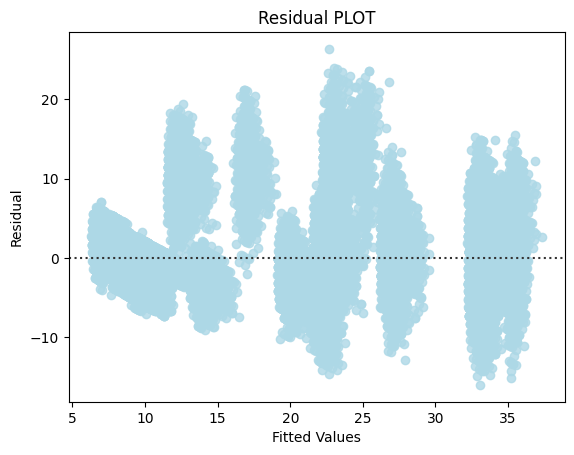

In [99]:
# Predicted values
fitted = olsmodel2.fittedvalues

# Plotting Residuals VS Fitted Values
sns.residplot(x = fitted, y = residual, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

**Observation:**

- We can observe that there is no pattern in the residuals vs fitted values scatter plot, i.e., the linearity assumption is satisfied.

### **No Heteroscedasticity**

* **Homoscedasticity:** If the variance of the residuals is symmetrically distributed across the regression line, then the data is said to be homoscedastic.

* **Heteroscedasticity:** If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case, the residuals can form an arrow shape or any other non-symmetrical shape.

* We will use `Goldfeld–Quandt` test to check homoscedasticity:

    * **Null hypothesis:** Residuals are homoscedastic

    * **Alternate hypothesis:** Residuals are hetroscedastic

    * **alpha = 0.05**

In [100]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residual, x_train2)
lzip(name, test)

[('F statistic', 1.0039164146411292), ('p-value', 0.1910731027168776)]

**Observation:**

- As we can observe from the above test, the p-value is greater than 0.05. So, we fail to reject the null-hypothesis, i.e., residuals are homoscedastic.

All the assumptions for the linear regression model are satisfied. With our model's adjusted R-squared value of around 0.84, we can capture **84% of the variation** in the data.

The p-values for the independent variables are less than 0.05 in our final model, indicating that they are statistically significant toward Length of Stay (in days) prediction.

Now, let's check and interpret the coefficients of the model.

In [102]:
coef = olsmodel2.params
coef

const                                    19.888611
Available Extra Rooms in Hospital         0.078611
Admission_Deposit                        -0.000038
Department_anesthesia                     6.082191
Department_gynecology                     0.462834
Department_radiotherapy                  -4.621748
Department_surgery                        9.685354
Ward_Facility_Code_B                      0.256912
Ward_Facility_Code_C                      0.435021
Ward_Facility_Code_D                      0.203221
Ward_Facility_Code_E                      0.308490
Ward_Facility_Code_F                      0.002702
doctor_name_Dr John                       7.262411
doctor_name_Dr Mark                       1.194666
doctor_name_Dr Nathan                    -0.212506
doctor_name_Dr Olivia                    -0.359233
doctor_name_Dr Sam                        1.283345
doctor_name_Dr Sarah                      0.818361
doctor_name_Dr Simon                      6.159364
doctor_name_Dr Sophia          

In [103]:
# Let us write the equation of the model
Equation = "Stay (in days)="
print(Equation, end='\t')
for i in range(len(coef)):
    print('(', coef[i], ') * ', coef.index[i], '+', end = ' ')

Stay (in days)=	( 19.888610855864403 ) *  const + ( 0.07861088283159112 ) *  Available Extra Rooms in Hospital + ( -3.842459927451045e-05 ) *  Admission_Deposit + ( 6.082190541593231 ) *  Department_anesthesia + ( 0.46283441248227 ) *  Department_gynecology + ( -4.621748096792428 ) *  Department_radiotherapy + ( 9.685354270363273 ) *  Department_surgery + ( 0.25691216690547164 ) *  Ward_Facility_Code_B + ( 0.4350214272584568 ) *  Ward_Facility_Code_C + ( 0.20322070575900716 ) *  Ward_Facility_Code_D + ( 0.30849012139843557 ) *  Ward_Facility_Code_E + ( 0.002701539809025613 ) *  Ward_Facility_Code_F + ( 7.262410614557625 ) *  doctor_name_Dr John + ( 1.1946664296565648 ) *  doctor_name_Dr Mark + ( -0.21250613917350614 ) *  doctor_name_Dr Nathan + ( -0.3592329257012279 ) *  doctor_name_Dr Olivia + ( 1.2833451288128876 ) *  doctor_name_Dr Sam + ( 0.8183606659496574 ) *  doctor_name_Dr Sarah + ( 6.159364331852164 ) *  doctor_name_Dr Simon + ( 0.21621281139694165 ) *  doctor_name_Dr Sophia +

### **Interpreting the Regression Coefficients**

* The Stay (in days) decreases with an increase in Department_radiotherapy. 1 unit increase in the Department_radiotherapy leads to a decrease of Stay (in days) ~ 4.62 times the Stay (in days) than the Department_TB&Chest_Disease that serves as a reference variable when everything else is constant.

* The Stay (in days) increases with an increase in Department_anesthesia. 1 unit increase in Department_anesthesia leads to an increase of Stay (in days) ~ 6.08 times the Stay (in days) than the Department_TB&Chest_Disease that serves as a reference variable when everything else is constant. This is understandable, as anesthesia is used in severe cases which results in more days of stay.

* The Stay (in days) increases with an increase in Department_surgery. 1 unit increase in Department_surgery leads to an increase of Stay (in days) ~ 9.68 times the Stay (in days) than the Department_TB&Chest_Disease that serves as a reference variable when everything else is constant. This is understandable, as surgery is conducted in severe cases which results in more days of stay.

* The Stay (in days) increases with an increase in doctor_name_Dr Simon. 1 unit increase in doctor_name_Dr Simon leads to an increase of Stay (in days) ~ 6.14 times the Stay (in days) than the doctor_name_Dr Isaac that serves as a reference variable when everything else is constant. This is understandable, as surgery cases are handled by Dr. Simon.

## Linear Regression

In [104]:
# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(x_train, y_train)

LinearRegression()

In [105]:
# Checking performance on the training data
linear_reg = model_performance_regression(model, x_train, y_train)
linear_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135093,2.146244,0.842813,0.842796,19.591833


In [106]:
# Checking performance on the testing data
linear_reg_test = model_performance_regression(model, x_test, y_test)
linear_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842964,19.676966


*Observations:**

- **The Root Mean Squared Error** and the **adjusted $R^2$** of train and test data are **very close**, indicating that **our model is not overfitting** to the training data.

- The adjusted $R^2$ of ~0.84 implies that the independent variables are able to explain ~84% variance in the target variable.

- Mean Absolute Error (MAE) indicates that the current model can predict LOS of patients within **mean error of 2.15 days** on the test data.

- The units of both RMSE and MAE are the same, i.e., days in this case. But RMSE is greater than MAE because it penalizes the outliers more.

- **Mean Absolute Percentage Error is ~19%** on the test data, indicating that the average difference between the predicted value and the actual value is ~19%.

**Regularization** is a fundamental concept in machine learning. It is a method of preventing the model from **overfitting** by adding additional information to it.

The machine learning model may perform well with training data but not with test data. It means that when dealing with unseen data, the model cannot anticipate the result since it introduces noise into the output, and so the model is termed **overfit**. A **regularization** technique can be used to solve this problem.

By lowering the magnitude of the variables, this technique allows for the preservation of all variables or features in the model. As a result, it maintains accuracy as well as model generalization.

Its primary function is to regularize or lower the coefficient of features towards zero. In other words, "the regularization strategy reduces the magnitude of the features while maintaining the same number of features."

Regularization is accomplished by introducing a penalty or complexity term into the complex model.

Regularization procedures are classified into two types, which are listed below:


- **Ridge Regression**
- **Lasso Regression**

## Ridge Regression

**Ridge regression** is a sort of linear regression in which a **small amount of bias** is introduced to improve long-term predictions.

- Ridge regression is a regularization technique that is **used to reduce model complexity**. It's also known as **$L_2$ regularization**.

- The penalty term is added to the cost function in this technique. The amount of bias introduced into the model is referred to as the **Ridge Regression penalty**.

- We may compute it by multiplying the squared weight of each individual feature by the alpha.

- In general, Ridge Regression calculates the equation's parameters:

$$\Large\ \hat{y}\  = slope \times X + y\ intercept$$

By minimizing the:

$$\Large\ the\ sum\ of\ squared\ residuals + \alpha \times slope^{2} $$ 

- As we can see from the above equation, if the values of $\alpha$ tend to **zero**, the equation becomes the linear regression model's cost function. As a result, for the **minimum value of $\alpha$**, the model will be similar to the linear regression model.

- Because a general linear or polynomial regression will fail if the independent variables are highly collinear, Ridge regression can be utilized to tackle such situations.
- When we have more parameters than samples, it is easier to solve problems using Ridge Regression.

In [107]:
ridge_model = Ridge() #creating Ridge Regression model
ridge_model.fit(x_train, y_train) # Fitting the data into the model

Ridge()

In [108]:
ridge_reg = model_performance_regression(ridge_model, x_test, y_test) #getting performance metrics on test data
ridge_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144057,2.155826,0.843028,0.842963,19.677968


**Observations:**

- The performance metrics are showing almost similar results as compared to the Least Squares method.

### Ridge Regression with optimized $\large\alpha$

In [109]:
folds = KFold(n_splits=10, shuffle=True, random_state=1) 
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]} 
model = Ridge()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [110]:
model_cv.best_params_ #getting optimised parameters for alpha

{'alpha': 0.1}

In [111]:
ridge_model_tuned = Ridge(alpha=0.1) ##creating Tuned Ridge Regression model using optimised alpha value
ridge_model_tuned.fit(x_train, y_train) # Fitting the data into the tuned model

Ridge(alpha=0.1)

In [112]:
ridge_reg_tuned = model_performance_regression(ridge_model_tuned, x_test, y_test) #getting performance metrics on test data
ridge_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155771,0.843028,0.842964,19.677066


**Observations:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.1.
- It can be observed that after tuning the parameters of Ridge Regression, the performance parameters does not change implying that Ridge Regression does not help in improving the model.

## Lasso Regression

**Lasso regression** is another regularisation technique for reducing model complexity. It is an abbreviation for **Least Absolute and Selection Operator.**

- It is identical to Ridge Regression except that the **penalty term only contains absolute weights** rather than a square of weights.


- Because it uses absolute data, it **can decrease the slope to zero**, whereas **Ridge Regression can only get close to zero**.

- It is also known as **$L_1$ regularisation**.

Fundamentally, Lasso Regression calculates the equation's parameters:

$$\Large\ \hat{y}\  = slope \times X + y\ intercept$$

By minimizing the:

$$\Large\ the\ sum\ of\ squared\ residuals + \alpha \times |slope| $$ 

### Lasso Regression with default parameters

In [113]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)

Lasso()

In [114]:
lasso_reg = model_performance_regression(lasso_model, x_test, y_test)
lasso_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.064339,3.873332,0.416006,0.415766,34.652716


**Observations:**

- After fitting the data into Lasso Regression Model with default value of alpha (=1), the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.
- We can tune the alpha to get the optimized value similar to Ridge Regression using Grid SearchCV.

### Lasso Regression with optimized $\large\alpha$

In [115]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [116]:
model_cv.best_params_

{'alpha': 0.001}

In [117]:
lasso_model_tuned = Lasso(alpha=0.001)
lasso_model_tuned.fit(x_train, y_train)

Lasso(alpha=0.001)

In [118]:
lasso_reg_tuned = model_performance_regression(lasso_model_tuned, x_test, y_test)
lasso_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144315,2.157198,0.843002,0.842938,19.702959


**Observation:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001.
- The performance metrics are showing similar results as compared to Least Squares method and Ridge Regression, implying that after adding the penalty, the model does not improve. 

## Elastic Net Regression

**Elastic Net** is a regularized regression model that combines $L_1$ and $L_2$ penalties, i.e., **lasso** and **ridge** regression. As a result, it performs a more efficient smoothing process.

- The elastic net includes the **penalty of lasso regression**, and **when used in isolation, it becomes the ridge regression**. 
- In the procedure of regularization with an elastic net, **first, the coefficient of ridge regression is determined**. 
- After this, a **lasso algorithm is performed on the ridge regression coefficient to shrink the coefficient**.
- It has two parameters to be set, $\large\alpha_1$ and $\large\alpha_2$ where $\large\alpha_1$ controls the $L_1$ penalty and $\large\alpha_2$ controls the $L_2$ penalty.

Instead of utilising two $\large\alpha$-parameters, we can use simply one $\large\alpha$ and one $L_1$-ratio-parameter, which sets the proportion of our $L_1$ penalty in relation to $\large\alpha$. If $\large\alpha = 1$ and $L_1$-ratio = 0.3, our $L_1$ penalty is multiplied by 0.3, and our $L_2$ penalty is multiplied by $1 - L_1-ratio = 0.7$.

$$\large{ElasticNetMSE = MSE(y,y_{pred}) + {\alpha \cdot (1 - L_1Ratio)} \sum_{i=1}^m{{|\theta_i|}+ {\alpha \cdot L_1Ratio} \sum_{i=1}^m{{|\theta_i|}}}}$$ 

### Elastic Net Regression with default parameters

In [121]:
elasticnet_model = ElasticNet()
elasticnet_model.fit(x_train, y_train)

ElasticNet()

In [122]:
elasticnet_reg = model_performance_regression(elasticnet_model, x_test, y_test)
elasticnet_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.556087,4.678504,0.317455,0.317175,40.121657


**Observations:**

- After fitting the data into Elastic Net Model with default value of alpha (=1) and l1_ratio, the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.
- We can tune the alpha to get the optimized value similar to Ridge Regression using Grid SearchCV.

### Elastic Net Regression with optimized $\alpha$ and $L_1-ratio$

In [123]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]}
model = ElasticNet()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
                         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]},
             return_train_score=True, scoring='r2')

In [124]:
model_cv.best_params_

{'alpha': 0.001, 'l1_ratio': 0.05}

In [125]:
elasticnet_model_tuned = ElasticNet(alpha=0.001, l1_ratio=0.05)
elasticnet_model_tuned.fit(x_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.05)

In [126]:
elasticnet_reg_tuned = model_performance_regression(elasticnet_model_tuned, x_test, y_test)
elasticnet_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.157478,2.178911,0.841685,0.84162,19.981572


**Observation**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001, and l1_ratio = 0.05.
- The performance metrics are showing almost similar results as compared to Least Squares method, Ridge Regression and Lasso Regression, implying that after tuning the Elastic Net, the model does not improve.

In [127]:
models= pd.concat([linear_reg_test,ridge_reg,ridge_reg_tuned,lasso_reg,lasso_reg_tuned,elasticnet_reg,
                   elasticnet_reg_tuned], axis=0) #combining all models into a single dataframe
models['Models'] = ['Least Squares', 'Ridge Regression', 'Ridge Regression Tuned', 'Lasso Regression',
                                      'Lasso Regression Tuned', 'Elastic Net Regression',
                    'Elastic Net Regression Tuned'] #adding names of the models as a column to the dataframe
models = models.iloc[:,[5, 0,1,2,3,4]] #ordering names of the models as the first column
models

,Models,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Least Squares,3.144055,2.155765,0.843028,0.842964,19.676966
0,Ridge Regression,3.144057,2.155826,0.843028,0.842963,19.677968
0,Ridge Regression Tuned,3.144055,2.155771,0.843028,0.842964,19.677066
0,Lasso Regression,6.064339,3.873332,0.416006,0.415766,34.652716
0,Lasso Regression Tuned,3.144315,2.157198,0.843002,0.842938,19.702959
0,Elastic Net Regression,6.556087,4.678504,0.317455,0.317175,40.121657
0,Elastic Net Regression Tuned,3.157478,2.178911,0.841685,0.841620,19.981572


**Observations:**

- As per the above result, the **Least Squares Method** is giving the best results as compared to other models. 
- Regularization technique does not offer any significant improvement to the performance metrics.
- So, we will apply some **Non Linear models** to check if the model performance improves or not.

### Forward Feature Selection using SequentialFeatureSelector

We will see how to use **SequentialFeatureSelector** to select a subset of key features using forward feature selection. It is a greedy search algorithm that is used to **reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d**. It is useful to automatically select a subset of the most relevant featuresthat are most relevant to the problem.

**Why should we do feature selection?**

- Reduces dimensionality
- Discards deceptive features; Deceptive features appear to aid learning on the training set but impair generalization
- Speeds training/testing


**How does forward feature selection work?**

* It starts with an empty model and adds variables one by one.
* In each forward step, you add the one variable that gives the highest improvement to your model.


We will use forward feature selection on all the variables.

**Parameters to pass in SequentialFeatureSelector:**

- **estimator:** scikit-learn classifier or regressor.

- **k_features:** int or tuple or str (default: 1). 

    - The number of features to choose, where k features equals the entire feature collection, can be specified as an integer.
    - The SFS will consider returning any feature combination between min and max that scored highest in cross-validation if a tuple containing a min and max value is provided. For example, instead of a set amount of characteristics k, the tuple (1, 4) will return any combination of 1 to 4 features.
    - A string argument such as "best" or "parsimonious". If you choose "best," the feature selector will provide the feature subset with the best cross-validation performance. If the input "parsimonious" is provided, the smallest feature subset that is within one standard error of the cross-validation performance will be chosen.
    
- **forward:** bool (default: True). Forward selection if True, backward selection otherwise.

- **floating:** bool (default: False). Adds a conditional exclusion/inclusion if True:

    - Sequential floating forward selection (SFFS) starts from the empty set.
    - After	each forward step, it performs backward	steps as long as the objective function increases.
    - Once it stops increasing, the forward selection is continued.

- **verbose:** int (default: 0), level of verbosity to use in logging. If 0 then no output, if 1then the number of features in the current set, and if 2 then detailed logging including timestamp and cv scores at each step.

- **scoring:** str, callable, or None (default: None). If None (default), uses 'accuracy' for sklearn classifiers and 'r2' for sklearn regressors.

- **cv:** int (default: 5). Integer or iterable yielding train, test splits. If cv is an integer and estimator is a classifier (or y consists of integer class labels) stratified k-fold. Otherwise, regular k-fold cross-validation is performed. No cross-validation if cv is None, False, or 0.

- **n_jobs:** int (default: 1). The number of CPUs to use for evaluating different feature subsets in parallel. -1 means 'all CPUs'.

In [129]:
# Initializing the model to pass to SFS
reg = LinearRegression()

# Forward Feature Selection
sfs = SFS(
    reg,
    k_features=x_train.shape[1],
    forward=True, 
    floating=False,
    scoring="r2",
    n_jobs=-1,  
    verbose=2,
    cv=5,
)

# Perform SFS
sfs = sfs.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: 

Now, let's plot the the model performance with addition of each feature. We will use the **plot_sequential_feature_selection** function for this. It has the following parameters:

- **metric_dict:** mlxtend.SequentialFeatureSelector.get_metric_dict() object, which is a dictionary with items where each dictionary value is a list with the number of iterations (number of feature subsets) as its length. The **dictionary keys** corresponding to these lists are as follows:
    - 'feature_idx': tuple of the indices of the feature subset 
    - 'cv_scores': list with individual CV scores 
    - 'avg_score': of CV average scores
    - 'feature_names': Name of features in the subset
    - 'ci_bound': confidence interval bound of the CV score average
    - 'std_dev': standard deviation of the CV score average 
    - 'std_err': standard error of the CV score average 

- **figsize:** tuple (default: None). Height and width of the figure.

- **kind:** str (default: "std_dev"). The kind of error bar or confidence interval in {'std_dev', 'std_err', 'ci', None}.

- **color:** str (default: "blue"). Color of the lineplot (accepts any matplotlib color name).

- **bcolor:** str (default: "steelblue"). Color of the error bars / confidence intervals (accepts any matplotlib color name).

- **marker:** str (default: "o"). Marker of the line plot (accepts any matplotlib marker name).

- **alpha:** float in [0, 1] (default: 0.2). Transparency of the error bars / confidence intervals.

- **ylabel:** str (default: "Performance"). Y-axis label.

- **confidence_interval:** float (default: 0.95). Confidence level if kind='ci'.

In [130]:
sfs.get_metric_dict()

{1: {'feature_idx': (5,),
  'cv_scores': array([0.48930483, 0.48939957, 0.49302582, 0.48922331, 0.4984959 ]),
  'avg_score': 0.4918898861031266,
  'feature_names': ('Department_gynecology',),
  'ci_bound': 0.004631493101644186,
  'std_dev': 0.003603458980122188,
  'std_err': 0.001801729490061094},
 2: {'feature_idx': (5, 6),
  'cv_scores': array([0.60393142, 0.60360277, 0.60160635, 0.60347042, 0.61046924]),
  'avg_score': 0.6046160397618205,
  'feature_names': ('Department_gynecology', 'Department_radiotherapy'),
  'ci_bound': 0.0039038189052533014,
  'std_dev': 0.0030373037338459795,
  'std_err': 0.0015186518669229895},
 3: {'feature_idx': (5, 6, 23),
  'cv_scores': array([0.64519204, 0.6466788 , 0.64365579, 0.64406087, 0.65136707]),
  'avg_score': 0.646190914266793,
  'feature_names': ('Department_gynecology',
   'Department_radiotherapy',
   'Age_31-40'),
  'ci_bound': 0.0035892679605037617,
  'std_dev': 0.002792572412501408,
  'std_err': 0.001396286206250704},
 4: {'feature_idx': (

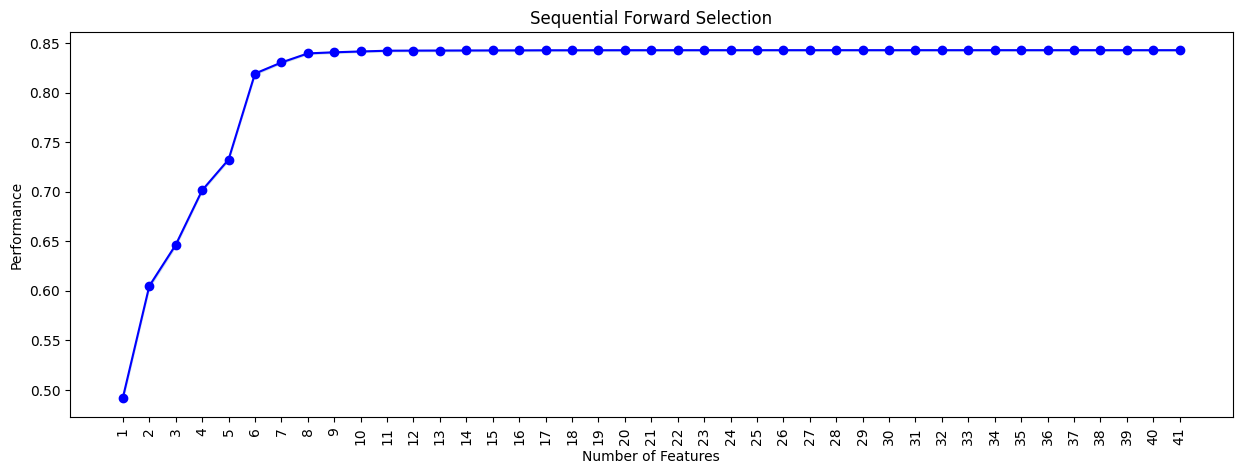

In [131]:
# To plot the performance of the model with addition of each feature
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=(15, 5))
plt.title("Sequential Forward Selection")
plt.xticks(rotation=90)
plt.show()

In [132]:
sfs.get_metric_dict()

{1: {'feature_idx': (5,),
  'cv_scores': array([0.48930483, 0.48939957, 0.49302582, 0.48922331, 0.4984959 ]),
  'avg_score': 0.4918898861031266,
  'feature_names': ('Department_gynecology',),
  'ci_bound': 0.004631493101644186,
  'std_dev': 0.003603458980122188,
  'std_err': 0.001801729490061094},
 2: {'feature_idx': (5, 6),
  'cv_scores': array([0.60393142, 0.60360277, 0.60160635, 0.60347042, 0.61046924]),
  'avg_score': 0.6046160397618205,
  'feature_names': ('Department_gynecology', 'Department_radiotherapy'),
  'ci_bound': 0.0039038189052533014,
  'std_dev': 0.0030373037338459795,
  'std_err': 0.0015186518669229895},
 3: {'feature_idx': (5, 6, 23),
  'cv_scores': array([0.64519204, 0.6466788 , 0.64365579, 0.64406087, 0.65136707]),
  'avg_score': 0.646190914266793,
  'feature_names': ('Department_gynecology',
   'Department_radiotherapy',
   'Age_31-40'),
  'ci_bound': 0.0035892679605037617,
  'std_dev': 0.002792572412501408,
  'std_err': 0.001396286206250704},
 4: {'feature_idx': (

**Observations:** 

- We can observe that the performance increases till the 8th feature and then becomes constant.
- The decision to choose the *k_features* now depends on the $R^2$ vs the complexity of the model.
    - With 8 features, we are getting an $R^2$ of 0.840.
    - With 20 features, we are getting an $R^2$ of 0.844.
    - With 42 features, we are getting an $R^2$ of 0.843.
- The increase in $R^2$ is not very significant as we are getting approximately the same values with a less complex model.
- So we'll use 8 features only to build the Linear Regression model, but you can experiment by taking a different number.
- Number of features chosen can also depend on the business context and use case of the model.

Let's run the Sequential Feature Selector again to find the best 8 features for the model.

In [133]:
reg = LinearRegression()

# Forward feature selection with 8 features
sfs = SFS(
    reg,
    k_features=8,
    forward=True,
    floating=False,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    cv=5,
)

# Perform SFFS
sfs = sfs.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/christopherpaskins/Projects/Machine Learning/mlvenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: 

In [134]:
# Selecting the features which are important for the model
feat_cols = list(sfs.k_feature_idx_)
print(feat_cols)

[4, 5, 6, 7, 21, 22, 23, 24]


In [135]:
# Checking the names of the important features
x_train.columns[feat_cols]

Index(['Department_anesthesia', 'Department_gynecology',
       'Department_radiotherapy', 'Department_surgery', 'Age_11-20',
       'Age_21-30', 'Age_31-40', 'Age_41-50'],
      dtype='object')

**Now, we will fit the Linear Regression model using these 8 features only.**

In [136]:
# Creating the new x_train data
x_train_final = x_train[x_train.columns[feat_cols]]

# Creating the new x_test data
x_test_final = x_test[x_train_final.columns]

# Fitting Linear Regression model on the new training data
lin_reg_model2 = LinearRegression()
lin_reg_model2.fit(x_train_final, y_train)

# Checking model performance on the training data
lin_reg_model2_train_perf = model_performance_regression(lin_reg_model2, x_train_final, y_train)
lin_reg_model2_train_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.167762,2.16747,0.83952,0.839516,19.769004


In [137]:
# Checking model performance on the testing data
lin_reg_model2_test_perf = model_performance_regression(lin_reg_model2, x_test_final, y_test)
lin_reg_model2_test_perf

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.175516,2.174951,0.839871,0.839858,19.83425


**Observations:**
- The performance looks approximately the same as the previous model with all the variables.
- Let's compare the two models we built.

In [138]:
# Training performance comparison

models_train_comp_df = pd.concat(
    [linear_reg.T, lin_reg_model2_train_perf.T], axis=1,
)

models_train_comp_df.columns = [
    "Linear Regression sklearn",
    "Linear Regression sklearn (SFS features)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Linear Regression sklearn,Linear Regression sklearn (SFS features)
RMSE,3.135093,3.167762
MAE,2.146244,2.167470
R-squared,0.842813,0.839520
Adj. R-squared,0.842796,0.839516
MAPE,19.591833,19.769004


In [139]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [linear_reg_test.T, lin_reg_model2_test_perf.T], axis=1,
)

models_test_comp_df.columns = [
    "Linear Regression sklearn",
    "Linear Regression sklearn (SFS features)",
]

print("Test performance comparison:")
models_test_comp_df

Test performance comparison:


,Linear Regression sklearn,Linear Regression sklearn (SFS features)
RMSE,3.144055,3.175516
MAE,2.155765,2.174951
R-squared,0.843028,0.839871
Adj. R-squared,0.842964,0.839858
MAPE,19.676966,19.834250


* The new model (**lin_reg_model2**) uses 8 features in comparison to 42 features for the previous model (**linear_reg**), i.e., the number of features has reduced by ~81%.
* The performance of the new model, however, is very close to our previous model.
* Depending upon time sensitivity and storage restrictions, we can choose between the models.